In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import pickle
import os

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:",device)

Mounted at /content/drive
Using: cuda


In [3]:
best_params = {'lstm_units': 64, 'learning_rate': 0.009885647542627366, 'weight_decay': 0.00959695196216962}
print(best_params)
best_lstm_units = best_params['lstm_units']
best_learning_rate = best_params['learning_rate']
best_weight_decay = best_params['weight_decay']

{'lstm_units': 64, 'learning_rate': 0.009885647542627366, 'weight_decay': 0.00959695196216962}


In [4]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True, bidirectional = True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        pooled = torch.mean(lstm_out, dim = 1)
        out = self.dropout(pooled)
        out = self.fc(out)
        return self.softmax(out)

In [5]:
model_dir = "/content/drive/My Drive/ADL Final Project/lstm_final_model"
model_path = os.path.join(model_dir, "bilstm_model.pth")
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")

# Load tokenizer
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

In [6]:
model = BiLSTMClassifier(vocab_size = 20000, embedding_dim = 100, hidden_dim = best_lstm_units, output_dim = 3,  dropout = 0.3).to(device)
model.load_state_dict(torch.load(model_path, map_location = device))
model.to(device)
model.eval()

BiLSTMClassifier(
  (embedding): Embedding(20000, 100)
  (lstm): LSTM(100, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [7]:
test_df = pd.read_csv("/content/drive/My Drive/ADL Final Project/yelp_dataset_test.csv")
test_sequences = tokenizer.texts_to_sequences(test_df['review_text'])
test_padded = pad_sequences(test_sequences, maxlen = 512, padding = 'post', truncating = 'post')

X_test_tensor = torch.tensor(test_padded, dtype = torch.long)
y_test_tensor = torch.tensor(test_df['class_index'].values, dtype = torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False)

# Short vs. Long Reviews


In [8]:
test_df['word_count'] = test_df['review_text'].apply(lambda x: len(x.split()))
short_reviews_df = test_df[test_df['word_count'] <= 50]
long_reviews_df = test_df[test_df['word_count'] > 50]

print(f"Short reviews: {len(short_reviews_df)}")
print(f"Long reviews: {len(long_reviews_df)}")

Short reviews: 7496
Long reviews: 22504


In [9]:
def predict_from_df(df, model, tokenizer, maxlen=512, batch_size=128):
    from torch.utils.data import DataLoader, TensorDataset
    import torch

    # Tokenize and pad
    sequences = tokenizer.texts_to_sequences(df['review_text'])
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

    X_tensor = torch.tensor(padded, dtype=torch.long)
    y_tensor = torch.tensor(df['class_index'].values, dtype=torch.long)

    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_preds = []
    all_labels = []

    device = next(model.parameters()).device  # Ensure correct device

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


--- Short Reviews ---
              precision    recall  f1-score   support

           0     0.8328    0.9123    0.8707      2200
           1     0.8156    0.7050    0.7562      1976
           2     0.8961    0.9117    0.9039      3320

    accuracy                         0.8574      7496
   macro avg     0.8481    0.8430    0.8436      7496
weighted avg     0.8563    0.8574    0.8552      7496



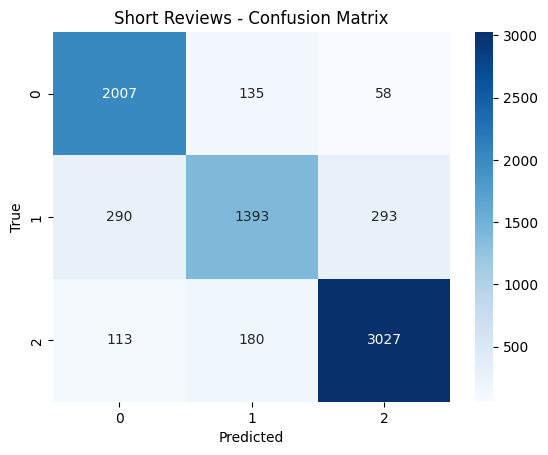


--- Long Reviews ---
              precision    recall  f1-score   support

           0     0.8636    0.9421    0.9011      7800
           1     0.8682    0.7954    0.8302      8024
           2     0.8891    0.8843    0.8867      6680

    accuracy                         0.8726     22504
   macro avg     0.8736    0.8739    0.8726     22504
weighted avg     0.8728    0.8726    0.8715     22504



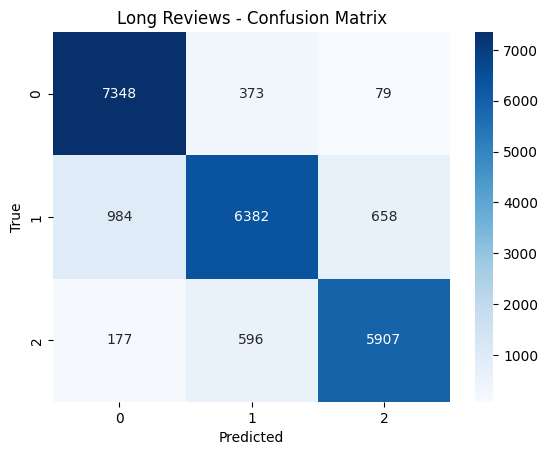

In [10]:
def evaluate_and_plot(df, description):
    y_true, y_pred = predict_from_df(df, model, tokenizer, maxlen=512)

    print(f"\n--- {description} Reviews ---")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{description} Reviews - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_and_plot(short_reviews_df, 'Short')
evaluate_and_plot(long_reviews_df, 'Long')

Short Review Accuracy: 0.8574
Long Review Accuracy: 0.8726


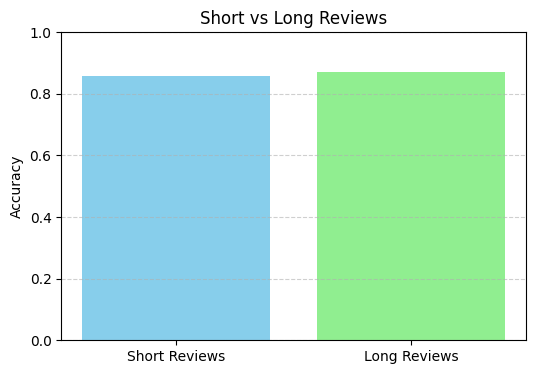

In [11]:
def get_accuracy(df, label):
    y_true, y_pred = predict_from_df(df, model, tokenizer, maxlen=512)
    acc = accuracy_score(y_true, y_pred)
    print(f"{label} Review Accuracy: {acc:.4f}")
    return acc

short_acc = get_accuracy(short_reviews_df, "Short")
long_acc = get_accuracy(long_reviews_df, "Long")

plt.figure(figsize=(6, 4))
plt.bar(['Short Reviews', 'Long Reviews'], [short_acc, long_acc], color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Short vs Long Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Vocabulary Analysis using LIME

In [12]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=184b69fbf058318636a65f588f8337272327e1c2e7e8dd3c495f521b75f79e6f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [13]:
from lime.lime_text import LimeTextExplainer
model = model.cpu()

class_names = ['negative', 'neutral', 'positive']

explainer = LimeTextExplainer(class_names=class_names)

def predict_proba_for_lime(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=512, padding='post', truncating='post')
    input_tensor = torch.tensor(padded, dtype=torch.long).to(next(model.parameters()).device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probs


In [14]:
from collections import Counter, defaultdict
import random

#Track the top words for each class
top_words_per_class = defaultdict(Counter)
N_SAMPLES = 100

# Sample 100 reviews per class
for class_idx, class_label in enumerate(class_names):
    class_df = test_df[test_df['class_index'] == class_idx].sample(N_SAMPLES, random_state=42)

    for text in class_df['review_text']:
        exp = explainer.explain_instance(text, predict_proba_for_lime, num_features=10, labels=[class_idx])
        influential_words = [word for word, weight in exp.as_list(label=class_idx)[:3]]  # Top 3 words
        top_words_per_class[class_label].update(influential_words)
        torch.cuda.empty_cache()


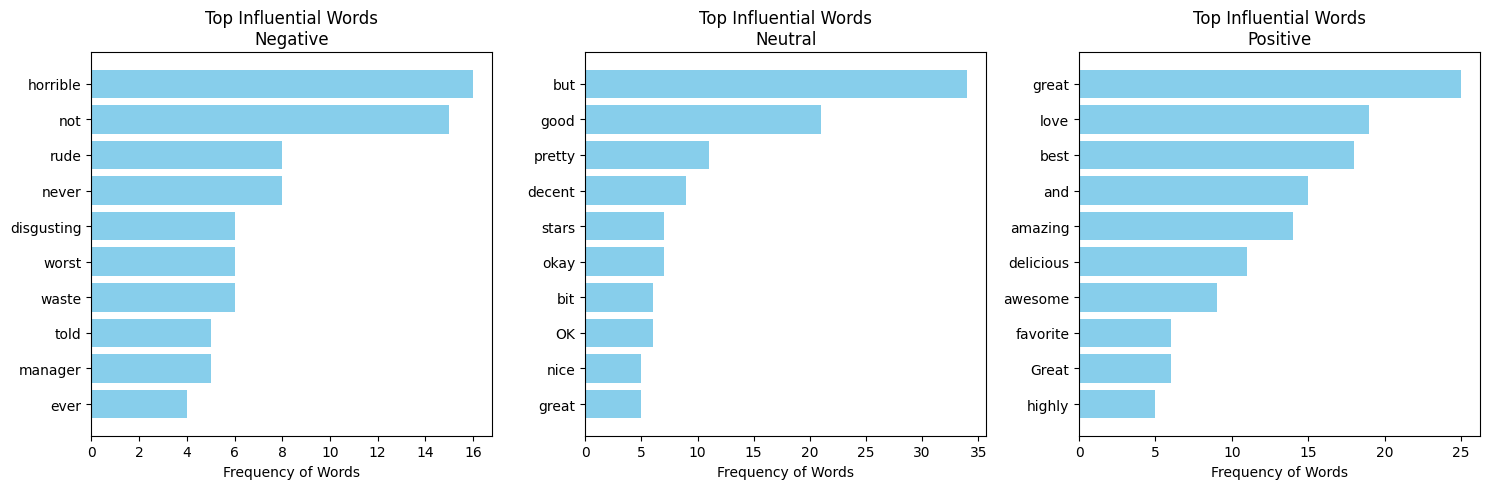

In [18]:
plt.figure(figsize=(15, 5))

for i, class_label in enumerate(class_names):
    top_words = top_words_per_class[class_label].most_common(10)
    words, counts = zip(*top_words)

    plt.subplot(1, 3, i+1)
    plt.barh(words, counts, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f"Top Influential Words\n{class_label.capitalize()}")
    plt.xlabel("Frequency of Words")

plt.tight_layout()
plt.show()